# Kickstarter Data Analysis
## Athly Sabish
## Max Beihoff
### 17 October, 2019

## Introduction
For this project we are looking at a data set of 300,000+ Kickstarter projects. We would like to find out if there are any variables that will help predict if the project will be successful or not.

## Hypothesis
We hypothesize that the `goal` and `main category` will be the best predictors in determining if a project will be successful or not.

## Data Set
* The data set was scraped from Kickstarter between 2012 and 2018

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date as date

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve

%matplotlib inline

c:\python37\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
raw_data = pd.read_csv("./kickstarter-projects/ks-projects-2018.csv")

In [3]:
raw_data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [4]:
raw_data.dtypes

ID                    int64
name                 object
category             object
main_category        object
currency             object
deadline             object
goal                float64
launched             object
pledged             float64
state                object
backers               int64
country              object
usd pledged         float64
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

## Data Preprocessing

* We drop the columns that are duplicates or uneccessary to our analysis

In [5]:
raw_data = raw_data.drop(['goal','pledged','usd pledged','ID','name','category'],axis=1)

### Main Category types

In [6]:
pd.value_counts(raw_data["main_category"].values)

Film & Video    63585
Music           51918
Publishing      39874
Games           35231
Technology      32569
Design          30070
Art             28153
Food            24602
Fashion         22816
Theater         10913
Comics          10819
Photography     10779
Crafts           8809
Journalism       4755
Dance            3768
dtype: int64

### Currency types

In [7]:
pd.value_counts(raw_data["currency"].values)

USD    295365
GBP     34132
EUR     17405
CAD     14962
AUD      7950
SEK      1788
MXN      1752
NZD      1475
DKK      1129
CHF       768
NOK       722
HKD       618
SGD       555
JPY        40
dtype: int64

## State Types

In [8]:
pd.value_counts(raw_data["state"].values)

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
dtype: int64

## Country Types

In [9]:
pd.value_counts(raw_data["country"].values)

US      292627
GB       33672
CA       14756
AU        7839
DE        4171
N,0"      3797
FR        2939
IT        2878
NL        2868
ES        2276
SE        1757
MX        1752
NZ        1447
DK        1113
IE         811
CH         761
NO         708
HK         618
BE         617
AT         597
SG         555
LU          62
JP          40
dtype: int64

In [10]:
raw_data["main_category"] = raw_data["main_category"].astype("category")

In [11]:
raw_data["currency"] = raw_data["currency"].astype("category").head()

In [12]:
raw_data["country"] = raw_data["country"].astype("category").head()

Convert dates in launched and deadline categories to datetime datatypes.

In [13]:
type(raw_data["deadline"][0])

str

In [14]:
raw_data["deadline"].head()

0    2015-10-09
1    2017-11-01
2    2013-02-26
3    2012-04-16
4    2015-08-29
Name: deadline, dtype: object

In [15]:
raw_data["launched"].head()

0    2015-08-11 12:12:28
1    2017-09-02 04:43:57
2    2013-01-12 00:20:50
3    2012-03-17 03:24:11
4    2015-07-04 08:35:03
Name: launched, dtype: object

In [16]:
date_format ="%Y-%m-%d"
dt.datetime.strptime(raw_data["deadline"][0], date_format)

datetime.datetime(2015, 10, 9, 0, 0)

In [17]:
converted_deadlines = raw_data["deadline"].map(lambda s: dt.datetime.strptime(s, date_format))
converted_deadlines.head()

0   2015-10-09
1   2017-11-01
2   2013-02-26
3   2012-04-16
4   2015-08-29
Name: deadline, dtype: datetime64[ns]

In [18]:
date_format ="%Y-%m-%d %H:%M:%S"
dt.datetime.strptime(raw_data["launched"][0], date_format)

datetime.datetime(2015, 8, 11, 12, 12, 28)

In [19]:
converted_launches = raw_data["launched"].map(lambda s: dt.datetime.strptime(s, date_format))
converted_launches.head()

0   2015-08-11 12:12:28
1   2017-09-02 04:43:57
2   2013-01-12 00:20:50
3   2012-03-17 03:24:11
4   2015-07-04 08:35:03
Name: launched, dtype: datetime64[ns]

In [20]:
dataDF = raw_data[raw_data["state"].isin(["successful", "failed"])]
dataDF["state"].value_counts

<bound method IndexOpsMixin.value_counts of 0             failed
1             failed
2             failed
3             failed
5         successful
             ...    
378654        failed
378657        failed
378658        failed
378659        failed
378660        failed
Name: state, Length: 331675, dtype: object>

In [21]:
dataDF["state"] = dataDF["state"].astype("category")

c:\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Analyze the data and variable relationships

### Goal vs Pledged
We can see that the high goals have low pledges, while low goals have high pledges.

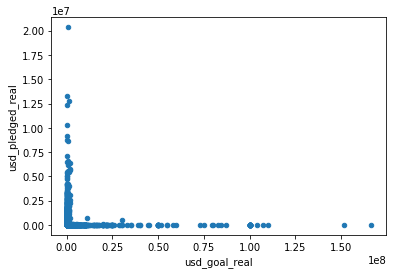

In [22]:
dataDF.plot.scatter(x="usd_goal_real",y="usd_pledged_real")

### Backers vs Pledged
There aren't many projects with over 100000 backer and we can see a large cluster of point near 0. As the the amount of backers increase the distribution of pledges fan out.

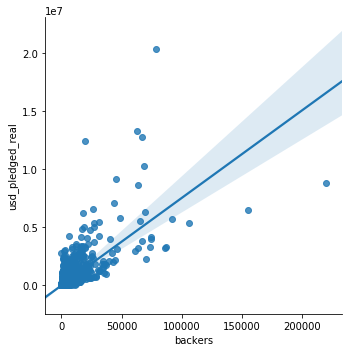

In [23]:
sns.lmplot(x='backers',y='usd_pledged_real',data=dataDF,fit_reg=True) 

### Backers vs Goal
This scatterplot is similar to the goal vs pledged scatterplot, where projects with high goals don't get many backers.

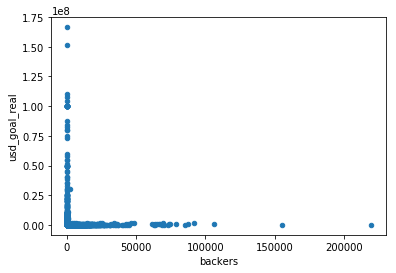

In [24]:
dataDF.plot.scatter(x="backers", y="usd_goal_real")

### Goal vs State
A boxplot relating the state with goal. We can see a large distribution between failed goals and all successful projects have small or reasonable goals.

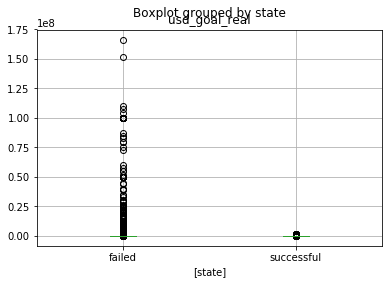

In [25]:
dataDF[["state","usd_goal_real"]].boxplot(by="state")

### Category vs Goal
We can see that most goals are clustered around a small number, while art, design, film/video, and technology have spreadout distributions. This doesn't take success or failure into account, but shows the expectations of the project owners.

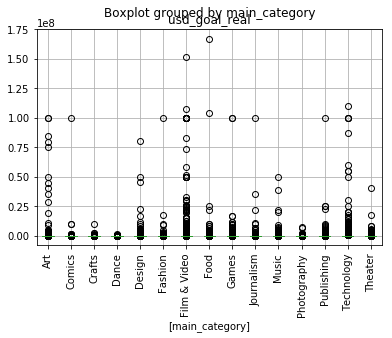

In [26]:
dataDF[["main_category","usd_goal_real"]].boxplot(by="main_category")
plt.xticks(rotation=90)
plt.show()

We need to count the number of successful projects and find the percentage of all projects that are successful. Then we can find which variales correlate to a high success rate.

In [27]:
def count_success(entries):
    #print(entries)
    successful = 0
    for entry in entries:
        if entry == "successful":
            successful = successful+1
    return successful/len(entries)

In [28]:
grouped = dataDF[["main_category", "state"]].groupby(["main_category"], as_index=False, sort=False)
grouped = grouped.aggregate(count_success)
grouped = grouped.rename(columns={"state" : "percent_successful"})
grouped

,main_category,percent_successful
0,Publishing,0.347017
1,Film & Video,0.417906
2,Music,0.526606
3,Food,0.275914
4,Crafts,0.270530
5,Games,0.438905
6,Design,0.415944
7,Comics,0.591415
8,Fashion,0.282832
9,Theater,0.637961


### Category vs Success Rate
We can see that dance, theater, comics, and music have success rates over 50%, so we hypothesize those categories will have an impact on the project success. 

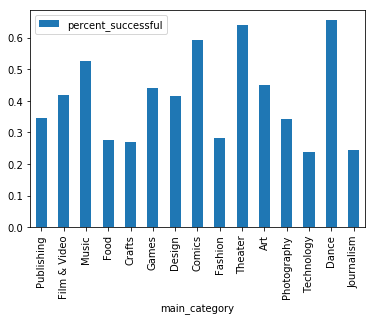

In [29]:
grouped.plot.bar(x="main_category", y="percent_successful")

### Heatmap of backers, pledged, and goal
There is a strong relationship between backers and pledged, but almost no relationship between goal and pledged or backers. The amount of pledges and backers are both the results of a successful project, so assume a strong correlation.

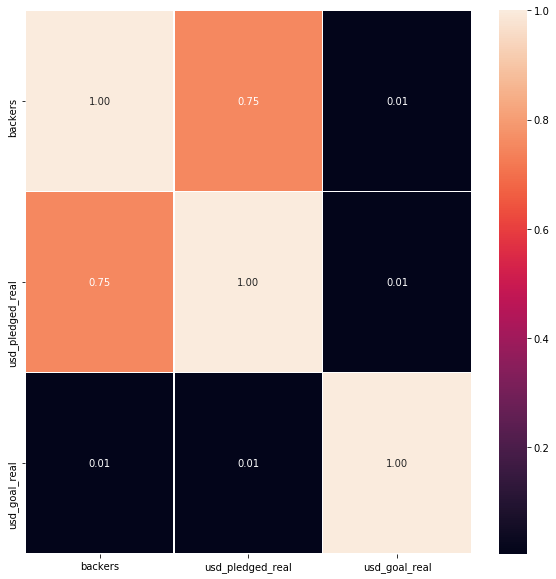

In [30]:
f,ax=plt.subplots(figsize=(10,10))
sns.heatmap(dataDF.corr(),annot=True,linewidths=.5,fmt=".2f",ax=ax)

## Data Modeling and Prediction

### Feature Extraction

Create a list of dummy variablese for each categorical variable.

In [31]:
cat_columns = ["main_category", "currency", "state", "country"]
dummy_columns = {}

for col in cat_columns:
    dummies = pd.get_dummies(dataDF[col], prefix=col)
    dummy_columns[col] = dummies.columns.values
    dataDF = dataDF.merge(dummies, left_index=True, right_index=True)
    
dataDF.head()

,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real,main_category_Art,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,failed,0,GB,0.0,1533.95,0,...,0,0,0,0,0,0,0,0,0,0
1,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,failed,15,US,2421.0,30000.00,0,...,0,0,0,0,0,0,0,0,0,1
2,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,failed,3,US,220.0,45000.00,0,...,0,0,0,0,0,0,0,0,0,1
3,Music,USD,2012-04-16,2012-03-17 03:24:11,failed,1,US,1.0,5000.00,0,...,0,0,0,0,0,0,0,0,0,1
5,Food,NaN,2016-04-01,2016-02-26 13:38:27,successful,224,NaN,52375.0,50000.00,0,...,0,0,0,0,0,0,0,0,0,0


## Set up Experiment

Create training and testing set.

In [32]:

df_train, df_test = train_test_split(dataDF, stratify=dataDF["state"])
print(dataDF.shape, df_train.shape, df_test.shape)

(331675, 63) (248756, 63) (82919, 63)


Use a label encoder to create a training and testing set of just the states of the projects for the base model.

In [33]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(df_train["state"].astype("str"))
y_test = encoder.transform(df_test["state"].astype("str"))
print(y_train[:25])

[0 0 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 0]


## Classification

### Simple Logistical Regression Model

Create a base model Simple Logical Regression model using the accuracy and confusion matrix metrics. Accuracy is the correctly classified samples divided by the total number of samples. A confusion matrix is used find why samples are predicted to be 'successful' or 'failed'. Only a diagonal in the matrix means that every prediction was correct.

### Null Model

In [44]:
print(df_train.shape)
zeros_train = np.zeros(df_train.shape)
zeros_test = np.zeros(df_test.shape)

base_lr = SGDClassifier(max_iter=100,tol=1e-3, loss="log")
base_lr.fit(zeros_train, y_train)

pred_base = base_lr.predict(zeros_test)
pred_probability = base_lr.predict_proba(zeros_test)

base_accuracy = accuracy_score(y_test, pred_base)
base_loss = log_loss(y_test,pred_probability)
cm = confusion_matrix(y_test, pred_base)

print("Base Accuracy:",base_accuracy)
print("Base Loss:", base_loss)
print("Base Labels:", encoder.classes_)
print("Base Confusion Matrix:\n", cm)

base_mse = mean_squared_error(y_test, pred_base)
base_rmse = np.sqrt(base_mse)

print("Base Model MSE:", base_mse)
print("Base Model RMSE:", base_rmse)

(248756, 63)
Base Accuracy: 0.5961239281708656
Base Loss: 0.6751193913116632
Base Labels: ['failed' 'successful']
Base Confusion Matrix:
 [[49430     0]
 [33489     0]]
Base Model MSE: 0.40387607182913443
Base Model RMSE: 0.6355124482094229


### Model using goal as selected variable

In [46]:
x_train = df_train[["usd_goal_real"]].astype("float64").values
x_test =df_test[["usd_goal_real"]].astype("float64").values

imputer = SimpleImputer()
x_train = imputer.fit_transform(x_train)
x_test = imputer.transform(x_test)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

simple_lr = SGDClassifier(max_iter=100,tol=1e-3, loss="log")
simple_lr.fit(x_train,y_train)
pred_state = simple_lr.predict(x_test)
pred_probability = simple_lr.predict_proba(x_test)

null_acc = accuracy_score(y_test,pred_state)
loss = log_loss(y_test, pred_probability)
cm = confusion_matrix(y_test, pred_state)

print("Goal Accuracy:",null_acc)
print("Goal Loss:",loss)
print("Goal Labels:",encoder.classes_)
print("Goal Confusion Matrix:\n",cm)
base_mse = mean_squared_error(y_test, pred_state)
base_rmse = np.sqrt(base_mse)

print("Base Model MSE:", base_mse)
print("Base Model RMSE:", base_rmse)

Goal Accuracy: 0.5961239281708656
Goal Loss: 0.6595275615157336
Goal Labels: ['failed' 'successful']
Goal Confusion Matrix:
 [[49430     0]
 [33489     0]]
Base Model MSE: 0.40387607182913443
Base Model RMSE: 0.6355124482094229


c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


### Greedy Algorithm Logistical Regression Model

A greedy algorithm will identify and select the variables that will improve the fit model. Those variables can be used to create the best model to predict the success of a project.

In [36]:
dataDF.columns[:25]

Index(['main_category', 'currency', 'deadline', 'launched', 'state', 'backers',
       'country', 'usd_pledged_real', 'usd_goal_real', 'main_category_Art',
       'main_category_Comics', 'main_category_Crafts', 'main_category_Dance',
       'main_category_Design', 'main_category_Fashion',
       'main_category_Film & Video', 'main_category_Food',
       'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'currency_AUD'],
      dtype='object')

We want to select the sub categories in main_category, currency, and country for our greedy algorithm

In [37]:
num_cols = ["usd_goal_real"]
cat_cols = []

for d in dummy_columns["main_category"]:
    cat_cols.append(d)
for d in dummy_columns["currency"]:
    cat_cols.append(d)
for d in dummy_columns["country"]:
    cat_cols.append(d)
    
cand_cols = num_cols + cat_cols

In [38]:
def create_feature_matrices(df_train, df_test, selected_columns, dummy_columns):
    """
    Creates feature matrices for the training and testing sets from the given dataframes.
    The feature matrices are built from the columns given in selected columns.
    """
    
    # keep track of numerical features
    numerical_trial_columns = []
    
    # keep track of dummy features for categorical variables
    categorical_trial_columns = []
    
    # build feature lists
    for col_name in selected_columns:
        if col_name in dummy_columns:
            categorical_trial_columns.extend(dummy_columns[col_name])
        else:
            numerical_trial_columns.append(col_name)

    # transform numerical features
    if len(numerical_trial_columns) > 0:
        X_train_numerical = df_train[numerical_trial_columns].astype("float64").values
        X_test_numerical = df_test[numerical_trial_columns].astype("float64").values
    
        imputer = SimpleImputer()
        X_train_numerical = imputer.fit_transform(X_train_numerical)
        X_test_numerical = imputer.transform(X_test_numerical)
    
        scaler = StandardScaler()
        X_train_numerical = scaler.fit_transform(X_train_numerical)
        X_test_numerical = scaler.transform(X_test_numerical)
    
    # select categorical features
    if len(categorical_trial_columns) > 0:
        X_train_categorical = df_train[categorical_trial_columns].astype("float64").values
        X_test_categorical = df_test[categorical_trial_columns].astype("float64").values
    
    # concatenate feature matrices
    if len(numerical_trial_columns) > 0 and len(categorical_trial_columns) > 0:
        X_train = np.hstack([X_train_numerical, X_train_categorical])
        X_test = np.hstack([X_test_numerical, X_test_categorical])
    elif len(numerical_trial_columns) > 0:
        X_train = X_train_numerical
        X_test = X_test_numerical
    else:
        X_train = X_train_categorical
        X_test = X_test_categorical
        
    return X_train, X_test

In [39]:
print("Null Model Accuracy:", base_accuracy)

col_accuracies = []
for col in cand_cols:
    x_train, x_test = create_feature_matrices(df_train,
                                             df_test,
                                             [col],
                                             {})
    
    simple_lr = SGDClassifier(max_iter=10, tol=1e-3,loss="log")
    simple_lr.fit(x_train, y_train)
    pred_state = simple_lr.predict(x_test)
    pred_probability = simple_lr.predict_proba(x_test)
    accuracy = accuracy_score(y_test, pred_state)
    loss = log_loss(y_test, pred_probability)
    print() 
    print(col + " Accuracy:", accuracy)
    print(col + " Loss:", loss)
    col_accuracies.append((accuracy, col))
    
col_accuracies.sort(key=lambda p: p[0], reverse=True)
sorted_columns = [col for _, col in col_accuracies]
print()
print("Sorted columns:" + str(sorted_columns))

Null Model Accuracy: 0.5961239281708656


c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



usd_goal_real Accuracy: 0.5961239281708656
usd_goal_real Loss: 0.6572818516859502

main_category_Art Accuracy: 0.5961239281708656
main_category_Art Loss: 0.6743184704506154

main_category_Comics Accuracy: 0.6015388511680073
main_category_Comics Loss: 0.6727384393858815

main_category_Crafts Accuracy: 0.5961239281708656
main_category_Crafts Loss: 0.6737597045667091

main_category_Dance Accuracy: 0.5995610173784054
main_category_Dance Loss: 0.6734279680739661

main_category_Design Accuracy: 0.5961239281708656
main_category_Design Loss: 0.6762990957125038

main_category_Fashion Accuracy: 0.5961239281708656
main_category_Fashion Loss: 0.6729334202029501

main_category_Film & Video Accuracy: 0.5961239281708656
main_category_Film & Video Loss: 0.6748356408503393

main_category_Food Accuracy: 0.5961239281708656
main_category_Food Loss: 0.6728241175694707

main_category_Games Accuracy: 0.5961239281708656
main_category_Games Loss: 0.6751704584634467

main_category_Journalism Accuracy: 0.596123

In [40]:
base_model_columns = []
base_loss = loss
base_accuracy = null_acc

print("Base Model Accuracy:", base_accuracy)
print("Base Model Loss:", base_loss)
print()

for col_name in sorted_columns:
    # track all column names
    trial_columns = base_model_columns[:]
    trial_columns.append(col_name)

    X_train, X_test = create_feature_matrices(df_train,
                                             df_test,
                                             trial_columns,
                                             {})
    
    trial_lr = SGDClassifier(max_iter=50,tol=1e-3, loss="log", penalty="l2")
    trial_lr.fit(X_train, y_train)
    pred_labels = trial_lr.predict(X_test)
    pred_prob = trial_lr.predict_proba(X_test)
    trial_accuracy = accuracy_score(y_test, pred_labels)
    trial_loss = log_loss(y_test, pred_prob)
    print()
    print(str(trial_columns) + " Model Accuracy:", trial_accuracy)
    print(str(trial_columns) + " Model Loss:", trial_loss)

    if trial_accuracy > base_accuracy:
        print("Updating base model")
        base_loss = trial_loss
        base_model_columns = trial_columns
        base_accuracy = trial_accuracy
    print()
    print("Base Model Loss:", base_loss)
    print("Base Model Accuracy:", base_accuracy)
    print()
    
print("Our chosen columns are: " + str(base_model_columns))

Base Model Accuracy: 0.5961239281708656
Base Model Loss: 0.6750590573697309


['main_category_Theater'] Model Accuracy: 0.6044211821174882
['main_category_Theater'] Model Loss: 0.6712610203228092
Updating base model

Base Model Loss: 0.6712610203228092
Base Model Accuracy: 0.6044211821174882


['main_category_Theater', 'main_category_Music'] Model Accuracy: 0.6125737165185301
['main_category_Theater', 'main_category_Music'] Model Loss: 0.6657941124306445
Updating base model

Base Model Loss: 0.6657941124306445
Base Model Accuracy: 0.6125737165185301


['main_category_Theater', 'main_category_Music', 'main_category_Comics'] Model Accuracy: 0.617988639515672
['main_category_Theater', 'main_category_Music', 'main_category_Comics'] Model Loss: 0.6646449822416902
Updating base model

Base Model Loss: 0.6646449822416902
Base Model Accuracy: 0.617988639515672


['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'main_category_Dance'] Model Accuracy: 0.6132731943221699
['

c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real'] Model Accuracy: 0.6243080596726927
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real'] Model Loss: 0.6484621940640158
Updating base model

Base Model Loss: 0.6484621940640158
Base Model Accuracy: 0.6243080596726927



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Art'] Model Accuracy: 0.6090401476139365
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Art'] Model Loss: 0.6503583361808952

Base Model Loss: 0.6484621940640158
Base Model Accuracy: 0.6243080596726927



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Crafts'] Model Accuracy: 0.6239221408844776
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Crafts'] Model Loss: 0.6475223197707314

Base Model Loss: 0.6484621940640158
Base Model Accuracy: 0.6243080596726927



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design'] Model Accuracy: 0.625188436908308
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design'] Model Loss: 0.6485165063562863
Updating base model

Base Model Loss: 0.6485165063562863
Base Model Accuracy: 0.625188436908308



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Fashion'] Model Accuracy: 0.6221252065268515
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Fashion'] Model Loss: 0.6462831708690592

Base Model Loss: 0.6485165063562863
Base Model Accuracy: 0.625188436908308



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Film & Video'] Model Accuracy: 0.6224749454286713
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Film & Video'] Model Loss: 0.6453360034655949

Base Model Loss: 0.6485165063562863
Base Model Accuracy: 0.625188436908308



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Food'] Model Accuracy: 0.6251522570219129
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Food'] Model Loss: 0.6463017295089262

Base Model Loss: 0.6485165063562863
Base Model Accuracy: 0.625188436908308



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Games'] Model Accuracy: 0.6212207093669726
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Games'] Model Loss: 0.6477511058575207

Base Model Loss: 0.6485165063562863
Base Model Accuracy: 0.625188436908308



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Journalism'] Model Accuracy: 0.622233746186037
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Journalism'] Model Loss: 0.6472038711677333

Base Model Loss: 0.6485165063562863
Base Model Accuracy: 0.625188436908308



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Photography'] Model Accuracy: 0.6229573439139401
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Photography'] Model Loss: 0.6480967019016869

Base Model Loss: 0.6485165063562863
Base Model Accuracy: 0.625188436908308



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Publishing'] Model Accuracy: 0.6251160771355178
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Publishing'] Model Loss: 0.6485777931777865

Base Model Loss: 0.6485165063562863
Base Model Accuracy: 0.625188436908308



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology'] Model Accuracy: 0.6265029727806655
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology'] Model Loss: 0.645571469331655
Updating base model

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'currency_AUD'] Model Accuracy: 0.6220407867919294
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'currency_AUD'] Model Loss: 0.6460841968479702

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'currency_CAD'] Model Accuracy: 0.6235844619447894
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'currency_CAD'] Model Loss: 0.645888213642282

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'currency_CHF'] Model Accuracy: 0.6233794425885503
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'currency_CHF'] Model Loss: 0.6487179919643822

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'currency_DKK'] Model Accuracy: 0.61060794269106
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'currency_DKK'] Model Loss: 0.6483496606669831

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'currency_EUR'] Model Accuracy: 0.6221252065268515
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'currency_EUR'] Model Loss: 0.6474914149405359

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'currency_GBP'] Model Accuracy: 0.6250316574005957
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'currency_GBP'] Model Loss: 0.64637756749124

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'currency_HKD'] Model Accuracy: 0.6113677203053582
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'currency_HKD'] Model Loss: 0.646720292310597

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'currency_JPY'] Model Accuracy: 0.6228126243683595
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'currency_JPY'] Model Loss: 0.6461973682410351

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'currency_MXN'] Model Accuracy: 0.6175062410304032
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'currency_MXN'] Model Loss: 0.6486170972812556

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'currency_NOK'] Model Accuracy: 0.6196529142898491
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'currency_NOK'] Model Loss: 0.6463777791805786

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'currency_NZD'] Model Accuracy: 0.6246457386123807
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'currency_NZD'] Model Loss: 0.6468582678793819

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'currency_SEK'] Model Accuracy: 0.622571425125725
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'currency_SEK'] Model Loss: 0.6456692098134538

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'currency_SGD'] Model Accuracy: 0.6232106031187062
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'currency_SGD'] Model Loss: 0.6461138095416847

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'currency_USD'] Model Accuracy: 0.6211483495941823
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'currency_USD'] Model Loss: 0.6478378896104313

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_AT'] Model Accuracy: 0.6254055162266791
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_AT'] Model Loss: 0.6462352365938454

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_AU'] Model Accuracy: 0.6221855063375101
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_AU'] Model Loss: 0.646130903109343

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_BE'] Model Accuracy: 0.6244286592940098
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_BE'] Model Loss: 0.6473816290087206

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_CA'] Model Accuracy: 0.6218357674356902
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_CA'] Model Loss: 0.6470950266620701

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_CH'] Model Accuracy: 0.624935177703542
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_CH'] Model Loss: 0.6458882257799338

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_DE'] Model Accuracy: 0.6221613864132467
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_DE'] Model Loss: 0.6460635935085723

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_DK'] Model Accuracy: 0.6127184360641108
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_DK'] Model Loss: 0.649466168083391

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_ES'] Model Accuracy: 0.6209071503515479
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_ES'] Model Loss: 0.6472914965469062

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_FR'] Model Accuracy: 0.6170238425451344
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_FR'] Model Loss: 0.648195610148326

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_GB'] Model Accuracy: 0.6240909803543216
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_GB'] Model Loss: 0.6459102838485361

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_HK'] Model Accuracy: 0.6250798972491226
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_HK'] Model Loss: 0.645524751058172

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_IE'] Model Accuracy: 0.6229091040654132
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_IE'] Model Loss: 0.6462542051113482

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_IT'] Model Accuracy: 0.6230538236109938
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_IT'] Model Loss: 0.6460630486797021

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_JP'] Model Accuracy: 0.6106682425017186
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_JP'] Model Loss: 0.6458846104174618

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_LU'] Model Accuracy: 0.6094260664021515
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_LU'] Model Loss: 0.6480081865207848

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_MX'] Model Accuracy: 0.6230297036867304
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_MX'] Model Loss: 0.6459864141228303

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_N,0"'] Model Accuracy: 0.625236676756835
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_N,0"'] Model Loss: 0.6454318723852741

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_NL'] Model Accuracy: 0.6247422183094345
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_NL'] Model Loss: 0.6470777456661932

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_NO'] Model Accuracy: 0.6220890266404564
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_NO'] Model Loss: 0.6459392985830973

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_NZ'] Model Accuracy: 0.6208468505408893
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_NZ'] Model Loss: 0.6463197885208638

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_SE'] Model Accuracy: 0.6247783981958297
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_SE'] Model Loss: 0.6472742503206906

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655



c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_SG'] Model Accuracy: 0.6220528467540611
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_SG'] Model Loss: 0.6456809772056024

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655


['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_US'] Model Accuracy: 0.6235965219069212
['main_category_Theater', 'main_category_Music', 'main_category_Comics', 'usd_goal_real', 'main_category_Design', 'main_category_Technology', 'country_US'] Model Loss: 0.6467553784483523

Base Model Loss: 0.645571469331655
Base Model Accuracy: 0.6265029727806655

Our chosen columns are: ['main_category_Theater', 'main_category_Music', 'main_category_

c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


In [47]:
X_train, X_test = create_feature_matrices(df_train,
                                          df_test,
                                          base_model_columns,
                                          {})
    
lr_greedy = SGDClassifier(max_iter=100, tol=1e-3, loss="log")
lr_greedy.fit(X_train, y_train)
pred_state_greedy = lr_greedy.predict(X_test)
trial_accuracy = accuracy_score(y_test, pred_state_greedy)
cm = confusion_matrix(y_test, pred_state_greedy)
print()
print("Greedy Model Accuracy:", trial_accuracy)
print("Greedy Labels:", encoder.classes_)
print("Greedy Confusion matrix:")
print(cm)
mse = mean_squared_error(y_test, pred_state_greedy)
rmse = np.sqrt(mse)

print("Greedy Model MSE:", mse)
print("Greedy Model RMSE:", rmse)


Greedy Model Accuracy: 0.6247060384230394
Greedy Labels: ['failed' 'successful']
Greedy Confusion matrix:
[[43097  6333]
 [24786  8703]]
Greedy Model MSE: 0.37529396157696066
Greedy Model RMSE: 0.6126124072992324


c:\python37\lib\site-packages\sklearn\linear_model\base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


Text(0, 0.5, 'True Positive Rate')

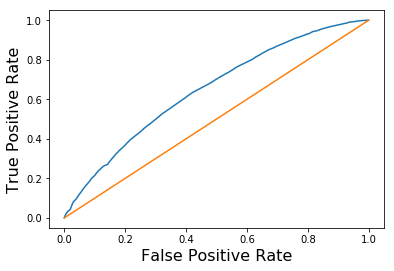

In [42]:
from sklearn.metrics import roc_curve

pred_proba = lr_greedy.predict_proba(X_test)

# turn multiclass problem into binary problem
pred_proba_1 = 1.0 - pred_proba[:, 0]
y_test_1 = [0 if y == 0 else 1 for y in y_test]

fpr, tpr, _ = roc_curve(y_test_1, pred_proba_1)

plt.plot(fpr, tpr)
plt.plot([0.0, 1.0], [0.0, 1.0])
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)

In the hypothesis it was believed that the projects goal and its main categories would be an indicator for a projects success. However, there was no difference beteen the RMSE for the null model and the model using the goal as the select variable. There was a small difference in the RMSE between null model and greedy model, but not enough to reject the null model. Therefore, neither goal amount or category type are a clear enough indicator for a project's success.